In [103]:
# Importaciones para manejo de datos y dataframes
import numpy as np
from numpy.random import seed
import pandas as pd

# Importaciones para manejo de archivos y llamadas al OS
import os as os
import warnings

# Importaciones para manejo de gráficos
import pylab as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.neighbors import LocalOutlierFactor

# Metemos un gridsearch
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel


from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector,VarianceThreshold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile
# Según el criterio chi-squared dustribution for it to have three features
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest
from sklearn import datasets, cluster


# No mostrar warnings de versiones anteriores
warnings.filterwarnings('ignore')

In [104]:
# EJEMPLO CON OPTUNA MUY CHULO: https://medium.com/@walter_sperat/using-optuna-with-sklearn-the-right-way-part-1-6b4ad0ab2451

# Cargamos csv con los datos de train
df_train = pd.read_csv("../data_raw/training_data.csv", sep=",", header=0, na_values=['?', '', 'NA'])
# Cargamos csv con los datos de test
df_test = pd.read_csv("../data_raw/test_data.csv", sep=",", header=0, na_values=['?', '', 'NA'])

In [105]:
## ENCODING

df_train_num = df_train.copy()
df_test_num = df_test.copy()

# 1. "OrdinalEncoder" para X24
orden_x24 = ['VLOW', 'LOW', 'MED', 'HIGH', 'VHIGH']

ordinal_encoder_x24 = OrdinalEncoder(categories=[orden_x24], dtype=int)

df_train_num['X24'] = ordinal_encoder_x24.fit_transform(df_train_num[['X24']])
df_test_num['X24'] = ordinal_encoder_x24.transform(df_test_num[['X24']])

# 2. "OrdinalEncoder" para X25
orden_x25 = ['NO', 'YES']

ordinal_encoder_x25 = OrdinalEncoder(categories=[orden_x25], dtype=int)

df_train_num['X25'] = ordinal_encoder_x25.fit_transform(df_train_num[['X25']])
df_test_num['X25'] = ordinal_encoder_x25.transform(df_test_num[['X25']])

# Si es VTKGN 1 else 0
# Ya que la la clase está muy desbalanceada
df_train_encoded = df_train_num.copy()
df_test_encoded = df_test_num.copy()

df_train_encoded.loc[df_train_num['X30'] == 'VTKGN', 'X30'] = 1
df_train_encoded.loc[df_train_num['X30'] != 'VTKGN', 'X30'] = 0

df_test_encoded.loc[df_test_num['X30'] == 'VTKGN', 'X30'] = 1
df_test_encoded.loc[df_test_num['X30'] != 'VTKGN', 'X30'] = 0

df_train_encoded['X30'] = pd.to_numeric(df_train_encoded['X30'])
df_test_encoded['X30'] = pd.to_numeric(df_train_encoded['X30']) 


In [106]:
# df_train_encoded
# df_test_encoded

In [107]:
## PREPROCESAMIENTO

df_train = df_train_encoded
df_test = df_test_encoded


# Preprocesamiento para TRAIN
df_final_train = df_train.drop(['ID','RATE'], axis=1, inplace=False)
train_ID = df_train['ID'].copy()
train_RATE = df_train['RATE'].copy()

# Preprocesamiento para TEST
df_final_test = df_test.drop('ID', axis=1, inplace=False)
test_ID = df_test['ID'].copy()



<Axes: xlabel='column', ylabel='value'>

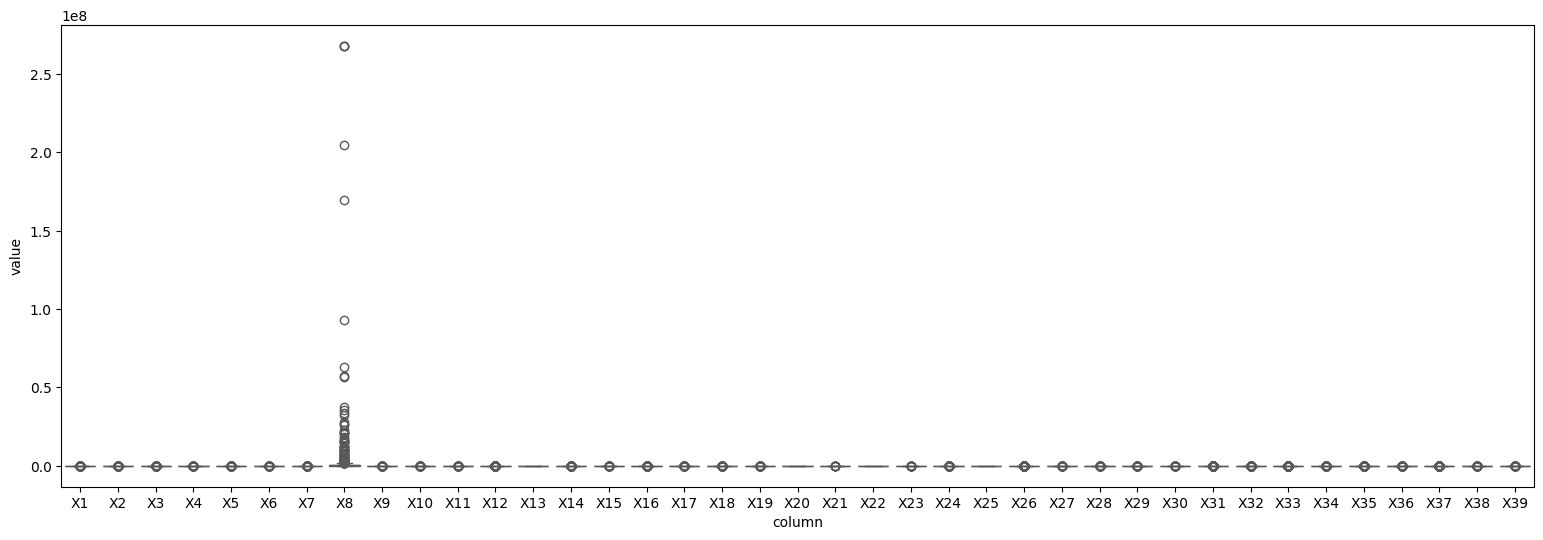

In [108]:

df_train_copy = df_final_train.copy()
df_test_copy = df_final_test.copy()

# Escala raíz cuadrada a las que se dispersan mucho
df_train_copy[['X1','X2','X3','X4','X5','X6','X7','X10','X11']] = np.sqrt(df_train_copy[['X1','X2','X3','X4','X5','X6','X7','X10','X11']])
df_test_copy[['X1','X2','X3','X4','X5','X6','X7','X10','X11']] = np.sqrt(df_test_copy[['X1','X2','X3','X4','X5','X6','X7','X10','X11']])


df_melted = df_train_copy.melt(var_name='column')

plt.figure(figsize=(19,6))
sns.boxplot(data=df_melted, color="#3BA3EC", x="column", y="value")

In [109]:
# df_train_copy
# df_test_copy

In [110]:
#1. Quitar outliers

modelo_isof = IsolationForest(
                n_estimators  = 1000,
                max_samples   ='auto',
                contamination = 0.1,
                n_jobs        = -1,
                random_state  = 123,
            )

df_no_na = df_train_copy.dropna(axis=0, inplace=False)

modelo_isof.fit(X=df_no_na)
clasificacion_predicha = modelo_isof.predict(X=df_no_na)
clasificacion_predicha

df_no_na['clasificacion_predicha'] = clasificacion_predicha
indices_outliers = df_no_na.index[df_no_na['clasificacion_predicha'] == -1].tolist()

indices_outliers

df_no_outliers = df_train_copy.drop(index=indices_outliers)

# Ahora, imputo sobre el dataset sin outliers
imp_train = KNNImputer(n_neighbors=5).fit(df_no_outliers)
df_train_imp = pd.DataFrame(imp_train.transform(df_train_copy), columns=df_train_copy.columns, index=df_train_copy.index)

# imp_train = SimpleImputer(missing_values=np.nan, strategy='median').fit(df_no_outliers) #most_frequent
# df_train_imp = pd.DataFrame(imp_train.transform(df_train_copy), columns=df_train_copy.columns, index=df_train_copy.index)

# Hago lo mismo para test

modelo_isof_test = IsolationForest(
                n_estimators  = 1000,
                max_samples   ='auto',
                contamination = 0.1,
                n_jobs        = -1,
                random_state  = 123,
            )

df_no_na_test = df_test_copy.dropna(axis=0, inplace=False)

modelo_isof_test.fit(X=df_no_na_test)
clasificacion_predicha = modelo_isof_test.predict(X=df_no_na_test)
clasificacion_predicha

df_no_na_test['clasificacion_predicha'] = clasificacion_predicha
indices_outliers = df_no_na_test.index[df_no_na_test['clasificacion_predicha'] == -1].tolist()

indices_outliers

df_no_outliers_test = df_test_copy.drop(index=indices_outliers)


imp_test = KNNImputer(n_neighbors=5).fit(df_no_outliers_test)
df_test_imp = pd.DataFrame(imp_test.transform(df_test_copy), columns=df_test_copy.columns, index=df_test_copy.index)

#Imputamos con mediana

# imp_test = SimpleImputer(missing_values=np.nan, strategy='median').fit(df_no_outliers_test)
# df_test_imp = pd.DataFrame(imp_test.transform(df_test_copy), columns=df_test_copy.columns, index=df_test_copy.index)



In [111]:
# df_train_imp
# df_test_imp

In [112]:
# # 4. Escalamos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_train_imp.to_numpy())
df_scaled = pd.DataFrame(df_scaled,index=df_train_imp.index, columns=[df_train_imp.columns])

df_scaled_test = scaler.transform(df_test_imp.to_numpy())
df_scaled_test = pd.DataFrame(df_scaled_test,index=df_test_imp.index, columns=[df_test_imp.columns])


# # 5. Componemos las columnas
columns = ['ID']
columns = np.append(columns, df_train_copy.columns)
columns = np.append(columns, 'RATE')

result_df_train = pd.merge(train_ID, df_scaled, left_index=True, right_index=True)
result_df_train = pd.merge(result_df_train, train_RATE, left_index=True, right_index=True)
result_df_train.columns = columns

columns = ['ID']
columns = np.append(columns, df_test_copy.columns)

result_df_test = pd.merge(test_ID, df_scaled_test, left_index=True, right_index=True)
result_df_test.columns = columns
  

In [113]:
# result_df_train
# result_df_test

In [137]:
# PROBANDO OPTUNA
import pickle
import optuna
from sklearn.preprocessing import StandardScaler, MinMaxScaler, KBinsDiscretizer, Normalizer, QuantileTransformer, PowerTransformer
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from tabulate import tabulate
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
import datetime

# Funciones individuales

def feature_top(X_train_in, y_train_in, X_val_in, X_test_in, k, type):
    
    match type:
        case 'tree':
            # Extracción de características
            clf = ExtraTreesClassifier(n_estimators=100)
            clf = clf.fit(X_train_in, y_train_in)

            model = SelectFromModel(clf, prefit=True, threshold=-np.inf, max_features=k)
            X_reduced = model.transform(X_train_in)

            selected_columns = X_train_in.columns[model.get_support()]
            X_train_out = pd.DataFrame(data=X_reduced, columns=selected_columns)

            X_val_out = X_val_in[selected_columns]
            X_test_out = X_test_in[selected_columns]


        case 'rf':
            
            clf = RandomForestClassifier(n_estimators = 200)
            clf.fit(X_train_in, y_train_in)
        
            model = SelectFromModel(clf, prefit=True, threshold=-np.inf, max_features=k)
            X_reduced = model.transform(X_train_in)

            selected_columns = X_train_in.columns[model.get_support()]
            
            X_train_out = pd.DataFrame(data=X_reduced, columns=selected_columns)
            X_val_out = X_val_in[selected_columns]
            X_test_out = X_test_in[selected_columns]


        case 'agglo':
            agglo = cluster.FeatureAgglomeration(n_clusters=k)
            agglo.fit(X_train_in)
            X_reduced = agglo.transform(X_train_in)
            
            cols = X_reduced.shape[1]
            selected_columns = [f"X{i+1}" for i in range(cols)]
            X_train_out = pd.DataFrame(data=X_reduced, columns=selected_columns)
            X_val_out   = pd.DataFrame(agglo.transform(X_val_in), columns=selected_columns)
            X_test_out  = pd.DataFrame(agglo.transform(X_test_in), columns=selected_columns)
            
            
        case 'kbest':
            fs = SelectKBest(score_func=f_classif, k=k)

            X_train_out = pd.DataFrame(fs.fit_transform(X_train_in, y_train_in))
            X_val_out   = pd.DataFrame(fs.transform(X_val_in))
            X_test_out  = pd.DataFrame(fs.transform(X_test_in))

    return X_train_out, X_val_out, X_test_out

def feature_perc(X_train_in, y_train_in, X_val_in, X_test_in, percent):
    fs = SelectPercentile(score_func=f_classif, percentile=percent)

    X_train_out = pd.DataFrame(fs.fit_transform(X_train_in, y_train_in))
    X_val_out   = pd.DataFrame(fs.transform(X_val_in))
    X_test_out  = pd.DataFrame(fs.transform(X_test_in))

    return X_train_out, X_val_out, X_test_out

def get_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    # print('Correlated Columns are: {}'.format(sorted(drops)))
    return drops

def delete_corr(X_train_in, X_val_in, X_test_in, corr_val):
    collinear_cols = get_collinear_features(X_train_in, corr_val)
    X_train_out = X_train_in.drop(columns=collinear_cols)
    X_val_out   = X_val_in.drop(columns=collinear_cols)
    X_test_out  = X_test_in.drop(columns=collinear_cols)

    return X_train_out, X_val_out, X_test_out

def down_sample(X_train_in, y_train_in,neigh):
    X_train_out, y_train_out = NearMiss(version=2, n_neighbors_ver3=neigh).fit_resample(X_train_in, y_train_in)
    #X_train_out, y_train_out = RandomUnderSampler(random_state=0,sampling_strategy='majority').fit_resample(X_train_in, y_train_in)

    return X_train_out, y_train_out

def up_sample(X_train_in, y_train_in, neigh):
    sm = SMOTE(random_state=16, k_neighbors=neigh)
    X_train_out, y_train_out = sm.fit_resample(X_train_in, y_train_in)

    return X_train_out, y_train_out


def up_down_sample(X_train_in, y_train_in, neigh, clase_a, clase_b, clase_c, clase_d, res_alg_typ):
    
    if(res_alg_typ == "random"):
        over = SMOTE(sampling_strategy = {'A': clase_a}, k_neighbors=neigh, random_state=16)
        under = RandomUnderSampler(sampling_strategy = {'B': clase_b, 'C':clase_c, 'D':clase_d})
        
        steps = [('o',over), ('u', under)]
        pipeline = Pipeline(steps=steps)

        X_train_out, y_train_out = pipeline.fit_resample(X_train_in, y_train_in)
    else:
        over = SMOTE(sampling_strategy = {'A': clase_a}, k_neighbors=neigh, random_state=16)
        under = NearMiss(version=2, n_neighbors_ver3=neigh)
        
        steps = [('o',over), ('u', under)]
        pipeline = Pipeline(steps=steps)

        X_train_out, y_train_out = pipeline.fit_resample(X_train_in, y_train_in)
    
    return X_train_out, y_train_out



def knn_stats(results, show_cf = True):
    
    header = ["Variant", "F1 Score", "Train Acc", "Test Acc", "Parameters"]
    body = []
    matrices = []

    for m in results:
        body.append([m, results[m]["val_stats"]["macro avg"]["f1-score"], results[m]["train_stats"]["accuracy"] * 100, results[m]["val_stats"]["accuracy"] * 100, results[m]["params"]])
        matrices.append(results[m]["val_conf"])
    print(tabulate(body, headers=header, floatfmt=".4f"))

    if(show_cf):
        fig, axes = plt.subplots(nrows=1, ncols=len(matrices), figsize=(18, 4))

        tick_labels = ["A", "B", "C", "D"]

        if(len(matrices) > 1):
            axes = axes.flatten()
        else:
            curr_ax = axes

        for i, model in enumerate(results):
            if(len(matrices) > 1):
                curr_ax = axes[i]

            sns.heatmap(matrices[i], ax=curr_ax, annot=True, xticklabels=tick_labels, yticklabels=tick_labels)
            curr_ax.title.set_text(model)
            curr_ax.set_xlabel("Predicted") 
            curr_ax.set_ylabel("Real") 

        plt.tight_layout()
        plt.show()


def to_kaggle(pred, id, path=".", fname="kaggle_out"):
    kaggle_dict = {"ID" : id, "RATE" : pred}
    pd.DataFrame(data=kaggle_dict).to_csv("{}/{}.csv".format(path, fname), index=False)

def get_kaggle_pred(model, data, id, path=".", fname="kaggle_out"):
    model_pred = model.predict(data)
    to_kaggle(model_pred, id, path=path, fname=fname)


class TuningParams:
    def __init__(self, X_data, y_data, X_test) -> None:
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(X_data, 
                                                            y_data, 
                                                            test_size=0.3, 
                                                            random_state=16,
                                                            shuffle=True)
        self.X_test = X_test.drop(columns=["ID"])
        self.X_test_ids = X_test["ID"]
        self.trial = {}



    def objective_function(self, trial):
        X_train = self.X_train
        y_train = self.y_train
        X_val   = self.X_val
        y_val   = self.y_val
        X_test  = self.X_test

        # Feature Selection
        do_feat_sel = trial.suggest_categorical("feature_selection", [True, False])

        if(do_feat_sel):
            #sel_type = trial.suggest_categorical("feat_sel_type", ["top", "perc"])
            sel_type = trial.suggest_categorical("feat_sel_type", ["top"])
            sel_model_type = trial.suggest_categorical("feat_sel_model", ["tree", "rf","agglo","kbest"])
                
            if(sel_type == "top"):
                best_k = trial.suggest_int("top_k", 5, 35)
                X_train, X_val, X_test = feature_top(X_train, y_train, X_val, X_test, best_k, sel_model_type)
            else:
                best_k = trial.suggest_int("perc", 5, 35)
                X_train, X_val, X_test = feature_perc(X_train, y_train, X_val, X_test, best_k)
           


        # Correlated Columns
        delete_correlated = trial.suggest_categorical("delete_correlated", [True, False])
        if(delete_correlated):
            corr_val = trial.suggest_float("corr_value", 0.5, 0.8)
            X_train, X_val, X_test = delete_corr(X_train, X_val, X_test, corr_val)
        

        # Under/Oversampling
        do_resampling = trial.suggest_categorical("resample", [True, False])

        if(do_resampling):
            
            kind = trial.suggest_categorical("kind", ["up", "down", "up_down"])
            if(kind == "up"):
                neigs = trial.suggest_int("up_neighs", 2, 33)
                X_train, y_train = up_sample(X_train, y_train, neigs)
            if(kind == "up_down"):    # [('A', 47), ('B', 245), ('C', 149), ('D', 129)]
                res_alg_type = trial.suggest_categorical("res_alg_typ", ["random", "near"])
                neigs = trial.suggest_int("up_neighs", 2, 33)
                clase_a = trial.suggest_int("clase_a", 70, 150)
                clase_b = trial.suggest_int("clase_b", 70, 150)
                clase_c = trial.suggest_int("clase_c", 70, 100)
                clase_d = trial.suggest_int("clase_d", 70, 100)
                X_train, y_train = up_down_sample(X_train, y_train, neigs, clase_a, clase_b, clase_c, clase_d, res_alg_type)
            else:
                # sampling_strat = trial.suggest_categorical('A', ["60", "70"])
                neigs = trial.suggest_int("up_neighs", 2, 33)
                X_train, y_train = down_sample(X_train, y_train,neigs)


        try:                                 
            algo = trial.suggest_categorical("algorithm", ['ball_tree', 'kd_tree', 'brute', 'auto'])     
            n_neighbors = trial.suggest_int("n_neighbors", 1, 33)
            weights = trial.suggest_categorical("weights", ['uniform', 'distance'])
            metric = trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski','chebyshev'])

            model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric, algorithm=algo)
            # grid = {
            #     'n_neighbors':n_neighbors, 
            #     'weights':weights, 
            #     'metric':metric, 
            #     'algorithm':algo
            # }
            # model = KNeighborsClassifier()
            # model = GridSearchCV(knn,param_grid=grid,cv=10) #GridSearchCV
        
            y_train_pred = model.fit(X_train, y_train).predict(X_train)
            y_val_pred   = model.predict(X_val)
            y_test_pred  = model.predict(X_test)

        except Exception as e: 
            print(e)
            return -1

        self.trial[trial.number] = {}
        self.trial[trial.number]["train_stats"] = classification_report(y_train, y_train_pred, output_dict=True, zero_division=0)
        self.trial[trial.number]["val_stats"]   = classification_report(y_val, y_val_pred, output_dict=True, zero_division=0)
        self.trial[trial.number]["val_conf"]    = confusion_matrix(y_val, y_val_pred)
        self.trial[trial.number]["train_pred"]  = y_train_pred
        self.trial[trial.number]["val_pred"]    = y_val_pred
        self.trial[trial.number]["test_pred"]   = y_test_pred
        self.trial[trial.number]["model"]       = model
        
        act_acc = self.trial[trial.number]["val_stats"]["accuracy"]
        act_f1  = self.trial[trial.number]["val_stats"]["macro avg"]["f1-score"]

        fitness = np.mean([act_acc, act_f1])

        self.trial[trial.number]["fitness"] = fitness

        return fitness

    def get_trial_test(self, num_trial):
        return self.trial[num_trial]

    def get_k_best_trials(self, study, k=5, save_kaggle=False, show_cf=True, path="."):
        trials = study.best_trials[:k]
        results = {}
        for t in trials:
            act_name = "{}__{}".format(study.study_name, t.number)
            act_result = self.get_trial_test(t.number)
            act_result["params"] = t.params

            results[act_name] = act_result
            if(save_kaggle):
                self.trial_to_kaggle(act_result, path = path, fname = act_name)

        knn_stats(results, show_cf=show_cf)
        return results

    def trial_to_kaggle(self, trial, path=".", fname = "kaggle_out"):
        to_kaggle(trial["test_pred"], self.X_test_ids, path=path, fname = fname)


In [138]:
df_credit_x = result_df_train.drop(['ID','RATE'],axis=1)
df_credit_y = result_df_train["RATE"]

df_test = result_df_test
X_test     = df_test.drop(columns=["ID"],axis=1)
X_test_ids = df_test["ID"]


BNTuning = TuningParams(df_credit_x, df_credit_y, df_test)
study = optuna.create_study(direction="maximize", study_name="tuning__{}".format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")), storage="sqlite:///db.sqlite3")

study.optimize(BNTuning.objective_function, n_trials=2000)

[I 2024-01-12 14:57:59,464] A new study created in RDB with name: tuning__20240112-145759
[I 2024-01-12 14:57:59,759] Trial 0 finished with value: -1.0 and parameters: {'feature_selection': False, 'delete_correlated': False, 'resample': False, 'algorithm': 'kd_tree', 'n_neighbors': 18, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 0 with value: -1.0.


Parameter grid for parameter 'n_neighbors' needs to be a list or a numpy array, but got 18 (of type int) instead. Single values need to be wrapped in a list with one element.


[I 2024-01-12 14:58:00,297] Trial 1 finished with value: -1.0 and parameters: {'feature_selection': False, 'delete_correlated': True, 'corr_value': 0.6462263590612116, 'resample': False, 'algorithm': 'brute', 'n_neighbors': 31, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 0 with value: -1.0.


Parameter grid for parameter 'n_neighbors' needs to be a list or a numpy array, but got 31 (of type int) instead. Single values need to be wrapped in a list with one element.


[I 2024-01-12 14:58:00,735] Trial 2 finished with value: -1.0 and parameters: {'feature_selection': True, 'feat_sel_type': 'top', 'feat_sel_model': 'kbest', 'top_k': 24, 'delete_correlated': True, 'corr_value': 0.5925522260226515, 'resample': True, 'kind': 'up_down', 'res_alg_typ': 'near', 'up_neighs': 19, 'clase_a': 98, 'clase_b': 96, 'clase_c': 81, 'clase_d': 75, 'algorithm': 'brute', 'n_neighbors': 26, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 0 with value: -1.0.


Parameter grid for parameter 'n_neighbors' needs to be a list or a numpy array, but got 26 (of type int) instead. Single values need to be wrapped in a list with one element.


[I 2024-01-12 14:58:00,973] Trial 3 finished with value: -1.0 and parameters: {'feature_selection': True, 'feat_sel_type': 'top', 'feat_sel_model': 'agglo', 'top_k': 20, 'delete_correlated': False, 'resample': False, 'algorithm': 'auto', 'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 0 with value: -1.0.


Parameter grid for parameter 'n_neighbors' needs to be a list or a numpy array, but got 6 (of type int) instead. Single values need to be wrapped in a list with one element.


[I 2024-01-12 14:58:01,387] Trial 4 finished with value: -1.0 and parameters: {'feature_selection': True, 'feat_sel_type': 'top', 'feat_sel_model': 'kbest', 'top_k': 31, 'delete_correlated': True, 'corr_value': 0.5301812424790285, 'resample': True, 'kind': 'up', 'up_neighs': 9, 'algorithm': 'kd_tree', 'n_neighbors': 4, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 0 with value: -1.0.


Parameter grid for parameter 'n_neighbors' needs to be a list or a numpy array, but got 4 (of type int) instead. Single values need to be wrapped in a list with one element.


[I 2024-01-12 14:58:01,746] Trial 5 finished with value: -1.0 and parameters: {'feature_selection': False, 'delete_correlated': True, 'corr_value': 0.5752705375618795, 'resample': True, 'kind': 'down', 'up_neighs': 8, 'algorithm': 'auto', 'n_neighbors': 27, 'weights': 'uniform', 'metric': 'chebyshev'}. Best is trial 0 with value: -1.0.
[W 2024-01-12 14:58:01,881] Trial 6 failed with parameters: {'feature_selection': False, 'delete_correlated': True, 'corr_value': 0.7035950589220666} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\U971574\AppData\Local\Temp\ipykernel_2168\2558383345.py", line 245, in objective_function
    X_train, X_val, X_test = delete_corr(X_train, X_val, X_test, corr_val)
                             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "

Parameter grid for parameter 'n_neighbors' needs to be a list or a numpy array, but got 27 (of type int) instead. Single values need to be wrapped in a list with one element.


KeyboardInterrupt: 

In [116]:
study.best_params

{'feature_selection': True,
 'feat_sel_type': 'top',
 'feat_sel_model': 'kbest',
 'top_k': 14,
 'delete_correlated': True,
 'corr_value': 0.5334211334867744,
 'resample': False,
 'algorithm': 'ball_tree',
 'n_neighbors': 23,
 'weights': 'distance',
 'metric': 'manhattan'}

In [117]:
a = study.best_trials

In [118]:
a

[FrozenTrial(number=1800, state=1, values=[0.6824149284247031], datetime_start=datetime.datetime(2024, 1, 12, 14, 20, 52, 216770), datetime_complete=datetime.datetime(2024, 1, 12, 14, 20, 52, 763028), params={'feature_selection': True, 'feat_sel_type': 'top', 'feat_sel_model': 'kbest', 'top_k': 14, 'delete_correlated': True, 'corr_value': 0.5334211334867744, 'resample': False, 'algorithm': 'ball_tree', 'n_neighbors': 23, 'weights': 'distance', 'metric': 'manhattan'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'feature_selection': CategoricalDistribution(choices=(True, False)), 'feat_sel_type': CategoricalDistribution(choices=('top',)), 'feat_sel_model': CategoricalDistribution(choices=('tree', 'rf', 'agglo', 'kbest')), 'top_k': IntDistribution(high=35, log=False, low=5, step=1), 'delete_correlated': CategoricalDistribution(choices=(True, False)), 'corr_value': FloatDistribution(high=0.8, log=False, low=0.5, step=None), 'resample': CategoricalDistribution(cho

In [119]:
study.best_trial.params

{'feature_selection': True,
 'feat_sel_type': 'top',
 'feat_sel_model': 'kbest',
 'top_k': 14,
 'delete_correlated': True,
 'corr_value': 0.5334211334867744,
 'resample': False,
 'algorithm': 'ball_tree',
 'n_neighbors': 23,
 'weights': 'distance',
 'metric': 'manhattan'}

In [120]:
self_trials = BNTuning.trial

In [121]:
BNTuning.trial = self_trials

Variant                          F1 Score    Train Acc    Test Acc  Parameters
-----------------------------  ----------  -----------  ----------  ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
tuning__20240112-140332__1800      0.6615     100.0000     70.3297  {'feature_selection': True, 'feat_sel_type': 'top', 'feat_sel_model': 'kbest', 'top_k': 14, 'delete_correlated': True, 'corr_value': 0.5334211334867744, 'resample': False, 'algorithm': 'ball_tree', 'n_neighbors': 23, 'weights': 'distance', 'metric': 'manhattan'}


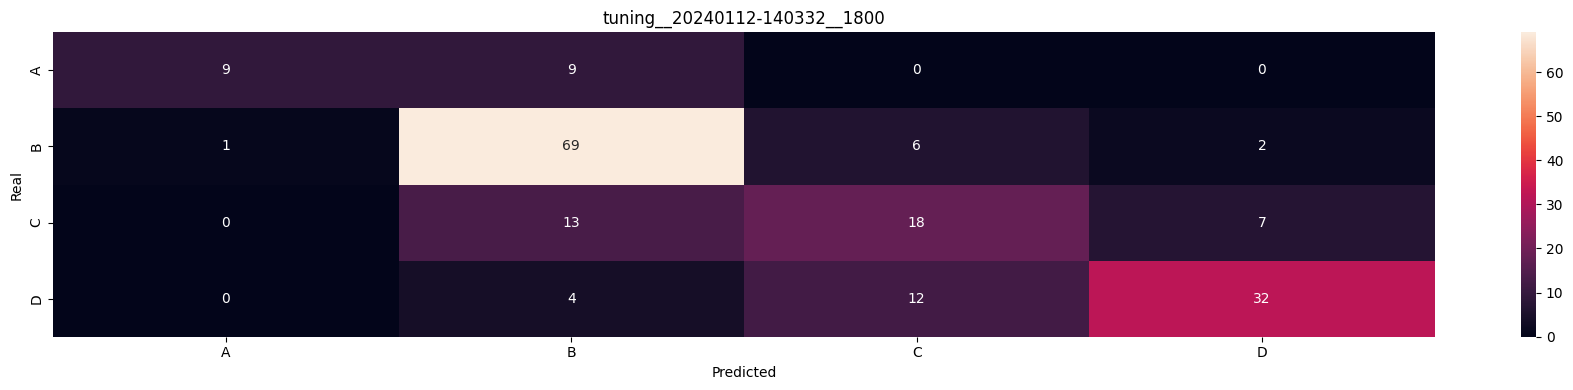

In [122]:
out = BNTuning.get_k_best_trials(study, k=1,save_kaggle=True)

In [110]:
out["tuning__20240111-165637__615"]["params"]

{'feature_selection': True,
 'feat_sel_type': 'top',
 'top_k': 22,
 'delete_correlated': False,
 'resample': False,
 'n_neighbors': 17,
 'weights': 'uniform',
 'metric': 'manhattan'}